In [3]:
# !pip3 install transformers
# !pip install gdown

In [4]:
from collections import defaultdict
import gdown
import gzip
import json
import random
import pickle

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
sns.set(style='ticks', font_scale=1.2)

In [5]:
# This is where our target data is hosted on the web. You only need these paths for the book review dataset.

genre_url_dict = {'poetry':                 'https://drive.google.com/uc?id=1FVD3LxJXRc5GrKm97LehLgVGbRfF9TyO',
                  'children':               'https://drive.google.com/uc?id=1908GDMdrhDN7sTaI_FelSHxbwcNM1EzR',
                  'comics_graphic':         'https://drive.google.com/uc?id=1V4MLeoEiPQdocCbUHjR_7L9ZmxTufPFe',
                  'fantasy_paranormal':     'https://drive.google.com/uc?id=1THnnmE4XSCvMkGOsqapQr2cJI5amKA6X',
                  'history_biography':      'https://drive.google.com/uc?id=1lDkTzM6zpYU-HGkVAQgsw0dBzik-Zde9',
                  'mystery_thriller_crime': 'https://drive.google.com/uc?id=1ONpyuv0vrtd6iUEp0-zzkKqwpm3njEqi',
                  'romance':                'https://drive.google.com/uc?id=1NpFsDQKBj_lrTzSASfyKbmkSykzN88wE',
                  'young_adult':            'https://drive.google.com/uc?id=1M5iqCZ8a7rZRtsmY5KQ5rYnP9S0bQJVo'}

In [6]:
for _genre, _url in genre_url_dict.items():
    gdown.download(_url, _genre + '.json.gz', quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1FVD3LxJXRc5GrKm97LehLgVGbRfF9TyO
To: /home/cgarcia37/Teaching/poetry.json.gz
100%|██████████| 49.3M/49.3M [00:01<00:00, 32.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1908GDMdrhDN7sTaI_FelSHxbwcNM1EzR
To: /home/cgarcia37/Teaching/children.json.gz
100%|██████████| 172M/172M [00:04<00:00, 38.0MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1V4MLeoEiPQdocCbUHjR_7L9ZmxTufPFe
To: /home/cgarcia37/Teaching/comics_graphic.json.gz
100%|██████████| 147M/147M [00:03<00:00, 37.9MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1THnnmE4XSCvMkGOsqapQr2cJI5amKA6X
To: /home/cgarcia37/Teaching/fantasy_paranormal.json.gz
100%|██████████| 1.26G/1.26G [00:19<00:00, 63.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lDkTzM6zpYU-HGkVAQgsw0dBzik-Zde9
To: /home/cgarcia37/Teaching/history_biography.json.gz
100%|██████████| 754M/754M [00:13<00:00, 55.5MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1ON

In [7]:
def load_reviews(file_name,
                 head=None):

    reviews = []
    count = 0

    with gzip.open(file_name) as file:
        for line in file:

            d = json.loads(line)
            count += 1

            _book_id = d['book_id']

            reviews.append(d['review_text'])

            # Break if we reach the Nth line
            if (head is not None) and (count > head):
                break

    return reviews

In [8]:
genres = ['poetry', 'children', 'comics_graphic', 'fantasy_paranormal', 'history_biography', 'mystery_thriller_crime', 'romance', 'young_adult']
genre_reviews_dict = {}

for _genre in genres:
    print('Loading ' + _genre + '.json.gz')
    _reviews = load_reviews(_genre + '.json.gz')
    genre_reviews_dict[_genre] = random.sample(_reviews, 2000)

Loading poetry.json.gz
Loading children.json.gz
Loading comics_graphic.json.gz
Loading fantasy_paranormal.json.gz
Loading history_biography.json.gz
Loading mystery_thriller_crime.json.gz
Loading romance.json.gz
Loading young_adult.json.gz


In [9]:
for _genre, _reviews in genre_reviews_dict.items():
    print('===========================')
    print(_genre)
    print('===========================')
    print(random.sample(_reviews, 1)[0])
    print()

poetry
Fun, silly poems combined with even more fun, unique collage artwork.

children
Prompt: a book you loved as a child. When I was in first grade, my teacher would read The Boxcar Children to my class. I loved the series and continued to check out the books from the library after the school year ended. This is the first time I've revisited these books and it brought back memories. Great light read and a great children's book!

comics_graphic
Well, this was a collection of short stories as the title implies. The Journal of John Ikos brought... John Ikos, Dane, and Billy (from Dead, Billy, Dead) together to go against a group of extremist vampires. The story was good, and it's always a pleasure to see Dane. The way that Dane and Ikos interacted was very believable... and I am curious as to where Norris is now. 
 Picking Up the Pieces didn't hit me as strongly as The Journal of John Ikos, but it was still an okay story. I would like a bit more variety, rather than destroying Barrow Pa

In [10]:
pickle.dump(genre_reviews_dict, open('genre_reviews_dict.pickle', 'wb'))
# genre_reviews_dict = pickle.load(open('genre_reviews_dict.pickle', 'rb'))

## Training and Test sets

In [11]:
train_texts = []
train_labels = []

test_texts = []
test_labels = []

for _genre, _reviews in genre_reviews_dict.items():

    _reviews = random.sample(_reviews, 1000) # Use a very small set as an example.
  
    for _review in _reviews[:800]:
        train_texts.append(_review)
        train_labels.append(_genre)
    for _review in _reviews[800:]:
        test_texts.append(_review)
        test_labels.append(_genre)

In [12]:
print("Train set: number of texts ", len(train_texts), "labels", len(train_labels))
print("Test set: number of texts ", len(test_texts), "labels", len(test_labels))

Train set: number of texts  6400 labels 6400
Test set: number of texts  1600 labels 1600


In [13]:
train_labels[0], train_texts[0]

('poetry',
 "Max Porter's Grief is the Thing with Feathers is a light little novella that delicately weaves together fable, poetry, and grief to dissect the healing of a family after the loss of a mother and wife. It's elegant even in its moments of vulgarity, and a very quick read that is at once delightful and a bit depressing. Melancholic, maybe, which is my word of the week. An excellent way to spend a couple of hours, especially on a grey and rainy day.")

## Baseline model

In [14]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [15]:
model = LogisticRegression(max_iter=1000).fit(X_train, train_labels)
predictions = model.predict(X_test)

In [16]:
print(classification_report(test_labels, predictions))

                        precision    recall  f1-score   support

              children       0.62      0.57      0.59       200
        comics_graphic       0.60      0.56      0.58       200
    fantasy_paranormal       0.35      0.30      0.33       200
     history_biography       0.47      0.46      0.46       200
mystery_thriller_crime       0.53      0.52      0.52       200
                poetry       0.57      0.71      0.63       200
               romance       0.42      0.45      0.43       200
           young_adult       0.36      0.37      0.36       200

              accuracy                           0.49      1600
             macro avg       0.49      0.49      0.49      1600
          weighted avg       0.49      0.49      0.49      1600



## Texts and labels for BERT


In [17]:
# This is the name of the BERT model that we want to use. 
# We're using DistilBERT to save space (it's a distilled version of the full BERT model), 
# and we're going to use the cased (vs uncased) version.
model_name = 'distilbert-base-cased'  

# This is the name of the program management system for NVIDIA GPUs. We're going to send our code here.
device_name = 'cuda'       

# This is the maximum number of tokens in any document sent to BERT.
max_length = 512                                                        

# This is the name of the directory where we'll save our model. You can name it whatever you want.
cached_model_directory_name = '/home/cgarcia37/Teaching/results/' 

In [18]:
# labels turned into integers.
# texts truncated/padded (512 tokens). Tokens separated into "word pieces" and matched to their embedding vectors.
# add special tokens: [CLS], [SEP], [PAD], [##]
# less frequent words will be split into two or more pieces. (prefix ##)

In [19]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name) # model_name = 'distilbert-base-cased'

## Labels

In [20]:
unique_labels = set(label for label in train_labels)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

In [47]:
label2id
#label2id.keys()
#label2id.values()
#label2id['poetry']

{'poetry': 0,
 'history_biography': 1,
 'young_adult': 2,
 'children': 3,
 'comics_graphic': 4,
 'mystery_thriller_crime': 5,
 'fantasy_paranormal': 6,
 'romance': 7}

In [48]:
id2label
#id2label.keys()
#id2label.values()
#id2label[0]

{0: 'poetry',
 1: 'history_biography',
 2: 'young_adult',
 3: 'children',
 4: 'comics_graphic',
 5: 'mystery_thriller_crime',
 6: 'fantasy_paranormal',
 7: 'romance'}

In [23]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in train_labels]
test_labels_encoded  = [label2id[y] for y in test_labels]

In [24]:
' '.join(train_encodings[3].tokens[0:100])

'[CLS] Find my book review here : https : / / the ##roy ##al ##pol ##ar ##be ##ar ##read ##s . word ##p ##r . . . " How could words can be so powerful and en ##chan ##ting ? " My first thought after reading the book . There are a significant power and advocacy that Amanda Love ##lace is trying to emphasize on making poet ##ries . It was vast . There \' s an impact . She can make simple words , into magnificent phrases , that has a double meaning behind bars . This is the'

In [25]:
train_texts[3]

'Find my book review here: https://theroyalpolarbearreads.wordpr... \n "How could words can be so powerful and enchanting?" My first thought after reading the book. There are a significant power and advocacy that Amanda Lovelace is trying to emphasize on making poetries. It was vast. There\'s an impact. She can make simple words, into magnificent phrases, that has a double meaning behind bars. \n This is the power of literature. From fiction books to poetry to contemporaries. It teaches us a lot of things. With Amanda Lovelace\'s poetry book, the princess saves herself in this one -- gave us a gripping, thrilling and exciting poetry that a person couldn\'t think to ask. It holds you dearly in the heart and crushes you with the full realization of her message. Wonderfully written and strucking lines that can make her readers stare at nothingness because of the surreality of her poems. \n One way or the another, I couldn\'t question this book as to why it became the Goodreads Choice Awar

In [26]:
' '.join(test_encodings[0].tokens[0:100])

'[CLS] " I feel love for all this , perhaps because I have nothing else to love . . . even though nothing truly merits the love of any soul , if , out of sentiment , we must give it , I might as well lavish it on the small ##ness of an ink ##well as on the grand in ##di ##fference of the stars . " [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [27]:
test_texts[0]

'"I feel love for all this, perhaps because I have nothing else to love ... even though nothing truly merits the love of any soul, if, out of sentiment, we must give it, I might as well lavish it on the smallness of an inkwell as on the grand indifference of the stars."'

In [28]:
set(train_labels_encoded)

{0, 1, 2, 3, 4, 5, 6, 7}

In [29]:
set(test_labels_encoded)

{0, 1, 2, 3, 4, 5, 6, 7}

## Torch dataset

In [40]:
#print(train_encodings[0].tokens, train_encodings[0].ids, train_encodings[0].attention_mask)
train_encodings[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [104]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [110]:
train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

In [114]:
' '.join(train_dataset.encodings[0].tokens[0:100])

'[CLS] Rene ##ging Q ##ui ##es ##cence is a glance into the heart of Sami ##ha Z ##uba ##ir . It is her rejection of still ##ness , her rejection of in ##action . She uses phrases that demand the reader pause and look more deeply . Yes , she could state her emotions in simpler terms , but that does not seem to be her goal . With language , Dr . Z ##uba ##ir adds ad ##orn ##ment to the m ##unda ##ne . Also , her word ##ings at time seem rough , but p ##olis ##h'

## Load the pretrained-model

In [115]:
# The model_name needs to match the name used for the tokenizer above.
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label)).to(device_name)

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier

## BERT fine-tuning parameters --> HuggingFace

In [116]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

In [117]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
  }

In [126]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset (usually a validation set; here we just send our test set)
    compute_metrics=compute_metrics      # our custom evaluation function 
)

In [127]:
trainer.train()

/home/cgarcia37/anaconda3/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
***** Running training *****
  Num examples = 6400
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  

Step,Training Loss,Validation Loss,Accuracy
100,0.854000,1.436626,0.513125
200,0.613100,1.498635,0.525000
300,0.410200,1.618877,0.528750


***** Running Evaluation *****
  Num examples = 1600
  Batch size = 80
/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 80
/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was aske

TrainOutput(global_step=300, training_loss=0.6257614517211914, metrics={'train_runtime': 113.9902, 'train_samples_per_second': 168.436, 'train_steps_per_second': 2.632, 'total_flos': 2543646198988800.0, 'train_loss': 0.6257614517211914, 'epoch': 3.0})

In [128]:
trainer.save_model(cached_model_directory_name)

Saving model checkpoint to /home/cgarcia37/Teaching/results/
Configuration saved in /home/cgarcia37/Teaching/results/config.json
Model weights saved in /home/cgarcia37/Teaching/results/pytorch_model.bin


In [129]:
#trainer = DistilBertForSequenceClassification.from_pretrained(cached_model_directory_name)

## Evaluate

In [130]:
trainer.evaluate()

/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 80
/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.6188769340515137,
 'eval_accuracy': 0.52875,
 'eval_runtime': 3.1855,
 'eval_samples_per_second': 502.277,
 'eval_steps_per_second': 6.278,
 'epoch': 3.0}

In [131]:
predicted_results = trainer.predict(test_dataset)

/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
***** Running Prediction *****
  Num examples = 1600
  Batch size = 80
/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [132]:
predicted_results.predictions.shape

(1600, 8)

In [133]:
predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability

In [134]:
len(predicted_labels)

1600

In [135]:
print(classification_report(test_labels, predicted_labels))

                        precision    recall  f1-score   support

              children       0.60      0.62      0.61       200
        comics_graphic       0.62      0.57      0.59       200
    fantasy_paranormal       0.38      0.41      0.39       200
     history_biography       0.53      0.52      0.53       200
mystery_thriller_crime       0.55      0.57      0.56       200
                poetry       0.72      0.72      0.72       200
               romance       0.49      0.45      0.47       200
           young_adult       0.35      0.36      0.36       200

              accuracy                           0.53      1600
             macro avg       0.53      0.53      0.53      1600
          weighted avg       0.53      0.53      0.53      1600



In [141]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 10):
    if _true_label == _predicted_label:
        print('LABEL:', _true_label)
        print('REVIEW TEXT:', _text[:100], '...')
        print()

LABEL: mystery_thriller_crime
REVIEW TEXT: One of the better in the series. Sadly little mention of his son, sister or (ex) fiance but as well  ...

LABEL: young_adult
REVIEW TEXT: This book did not disappoint me at all! I really enjoyed it and I thought it was very different from ...

LABEL: poetry
REVIEW TEXT: Small Arguments is dedicated "To my parents for knowing the weight of how much". The meaning of this ...

LABEL: poetry
REVIEW TEXT: nSwS 'dby@ qSyr@ wtharyW@ , flsf@ bthyn@ fy wjwh lHy@ lmt`dd@ , 'qSyS tbd' bklm@ wtnthy bHqyq@ mryr@ ...

LABEL: romance
REVIEW TEXT: I forgot how intense these two were but I freaking love them. I love them all. Jake and Abby. A.j. A ...

LABEL: comics_graphic
REVIEW TEXT: What I've always loved about comics and cartoons is the way they can introduce you to moments in his ...



In [142]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 10):
    if _true_label != _predicted_label:
        print('TRUE LABEL:', _true_label)
        print('PREDICTED LABEL:', _predicted_label)
        print('REVIEW TEXT:', _text[:100], '...')
        print()

TRUE LABEL: comics_graphic
PREDICTED LABEL: young_adult
REVIEW TEXT: I actually liked this second book a little better than the first... and that's saying something. ...

TRUE LABEL: fantasy_paranormal
PREDICTED LABEL: poetry
REVIEW TEXT: mjld qSS lf lyl@ wlyl@ mmt` wmsly wldhydh { mtftH wl SfHh mtHs l nt bkhr SfHh } 
 sm`t Hd lqr ljnb q ...

TRUE LABEL: comics_graphic
PREDICTED LABEL: poetry
REVIEW TEXT: This is a funny one cause everytime I see the cover I think 'oh yeah this is the one I didn't like'  ...

TRUE LABEL: romance
PREDICTED LABEL: young_adult
REVIEW TEXT: Picked up where the last one left off. Nila is being taken away and saved, it really happened, but.. ...

TRUE LABEL: fantasy_paranormal
PREDICTED LABEL: history_biography
REVIEW TEXT: There's a reason that the old wives' tale of "It seems too good to be true, it is." still holds thro ...

TRUE LABEL: children
PREDICTED LABEL: comics_graphic
REVIEW TEXT: A picture book that makes your heart stop when you get to a certai

In [143]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
    genre_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
    dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre', 
                                 columns='Predicted Genre', 
                                 values='Number of Classifications')

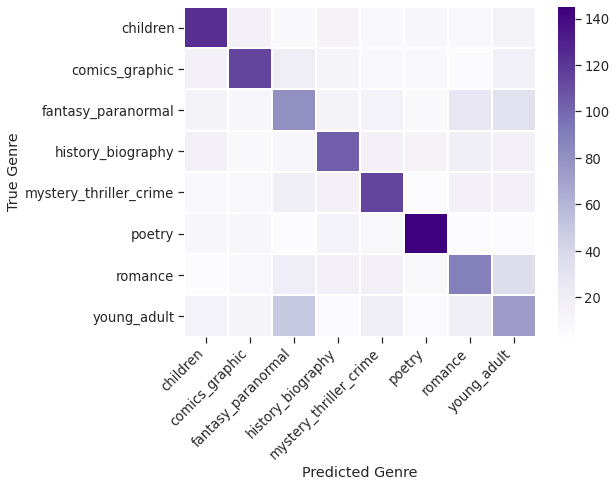

In [144]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [145]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
    if _true_label != _predicted_label: # Remove the diagonal to highlight misclassifications
        genre_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
    dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre', 
                                 columns='Predicted Genre', 
                                 values='Number of Classifications')

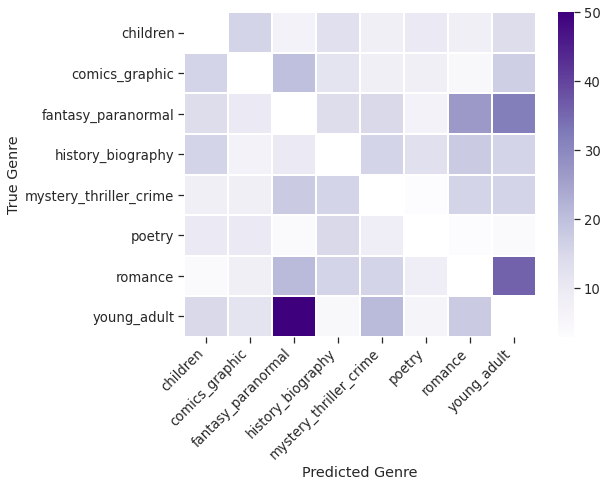

In [146]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()